In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('axes', labelsize=12)
plt.rcParams.update({'figure.figsize':(10,5)})


____
# Load Data
____

In [129]:
corrFolder = './correlation/'

corr_raw_day = pd.read_csv(corrFolder + 'correlation_hy_0305.csv')
corr_raw_month = pd.read_csv(corrFolder + 'correlation_hy_05.csv')

corr_hpca_day = pd.read_csv(corrFolder + 'correlation_hpca_0305.csv')
corr_hpca_month = pd.read_csv(corrFolder + 'correlation_hpca_05.csv')

tickers_sectors_day = np.load('corrected_tickers_sectors_filtered.npy')
tickers_sectors_month = np.load('corrected_tickers_sectors.npy')

assetFolder = './asset/'

returns_day = pd.read_parquet(assetFolder + 'AAP-trade_daily.parquet')
returns_month = pd.read_parquet(assetFolder + 'AAP-trade_monthly.parquet')

returns_day_degarch = pd.read_parquet(assetFolder + 'AAP-trade_daily_degarch.parquet')
returns_month_degarch = pd.read_parquet(assetFolder + 'AAP-trade_monthly_degarch.parquet')



___
# Plotting
___

- ### Log-Returns

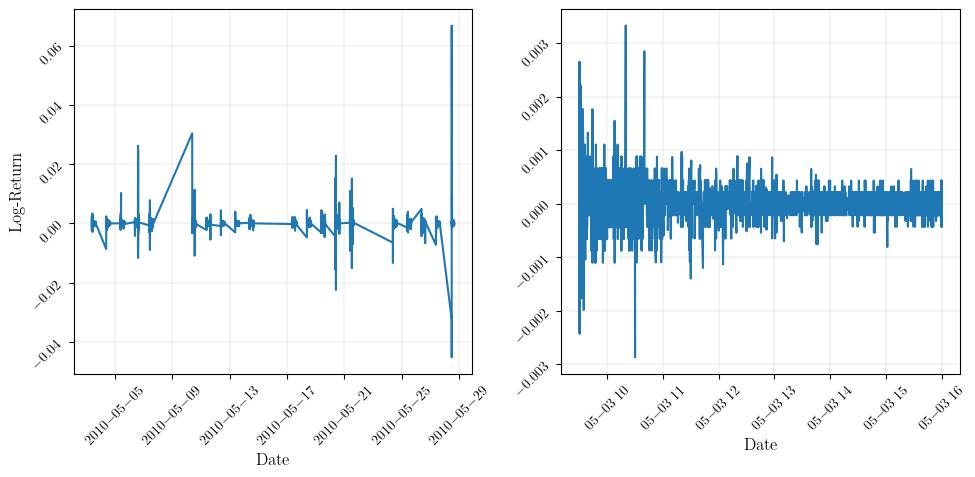

In [130]:
fig, ax = plt.subplots(1, 2)

sns.lineplot(x="index", y="log-return", data=returns_month, ax=ax[0])
#ax[0].set_title('Monthly log-returns')
ax[0].set_xlabel('Date')
ax[0].tick_params(labelrotation=45)
ax[0].set_ylabel("Log-Return")
ax[0].grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)

sns.lineplot(x="index", y="log-return", data=returns_day, ax=ax[1])
#ax[1].set_title('Daily log-returns')
ax[1].set_xlabel('Date')
ax[1].set_ylabel("")
ax[1].tick_params(labelrotation=45)
ax[1].grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)

plt.tight_layout()
plt.savefig('../figures/log_returns.pdf', dpi=300)

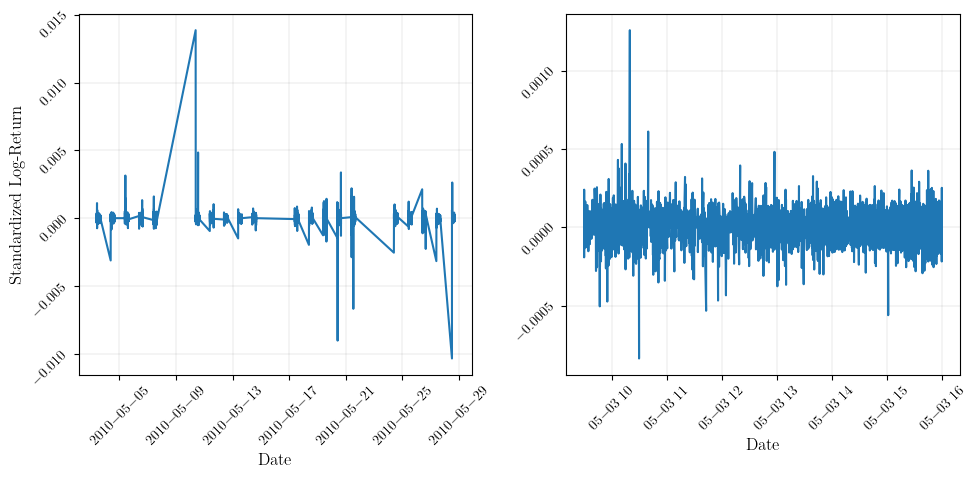

In [131]:
fig, ax = plt.subplots(1, 2)

sns.lineplot(x="index", y="log-return", data=returns_month_degarch, ax=ax[0])
#ax[0].set_title('Monthly deGARCHed log-returns')
ax[0].set_xlabel('Date')
ax[0].tick_params(labelrotation=45)
ax[0].set_ylabel("Standardized Log-Return")
ax[0].grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)

sns.lineplot(x="index", y="log-return", data=returns_day_degarch, ax=ax[1])
#ax[1].set_title('Daily deGARCHed log-returns')
ax[1].set_xlabel('Date')
ax[1].set_ylabel("")
ax[1].tick_params(labelrotation=45)
ax[1].grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)

plt.tight_layout()
plt.savefig('../figures/log_returns_degarched.pdf', dpi=300)

- ### Correlation Matrices

In [132]:

N_filtered = 278
N_unfiltered = 304

T = 10**4

def eigenvalue_clipping(eigvals, eigvecs, N, T, sigma2):
    q = N/T

    lambda_p = sigma2*(1+np.sqrt(q))**2
    N_clip = np.sum(np.where(eigvals<=lambda_p, 1, 0))
    delta = (N - np.sum(np.where(eigvals>=lambda_p, eigvals, 0)))/N_clip
    eig_clip = np.where(eigvals<=lambda_p, delta, eigvals)

    C_clip = eigvecs.T@np.diag(eig_clip)@eigvecs
    eigvals_clean, eigvecs_clean = np.linalg.eig(C_clip)

    return eigvals_clean, eigvecs_clean

# Marchenko-Pastur Distribution

def MP0(lambdas, N, T,sigma2, lower_lim, upper_lim):
    q = N/T
    x = np.linspace(lower_lim, upper_lim, 10000)
    lambda_plus = sigma2*(1+np.sqrt(q))**2
    lambda_minus = sigma2*(1-np.sqrt(q))**2

    vals = (lambda_plus-x)*(x-lambda_minus)
    
    vals = np.where(vals>0, 1/(q*2*np.pi*x*sigma2)*np.sqrt(vals), 0)

    return x, vals

In [133]:
eigvals_day, eigvecs_day = np.linalg.eig(corr_raw_day.iloc[:,1:].to_numpy())
eigvals_month, eigvecs_month = np.linalg.eig(corr_raw_month.iloc[:,1:].to_numpy())

eigvals_clipped_day, eigvecs_clipped_day = eigenvalue_clipping(eigvals_day, eigvecs_day, N_filtered, T, 1)
eigvals_clipped_month, eigvecs_clipped_month = eigenvalue_clipping(eigvals_month, eigvecs_month, N_filtered, T, 1)

corr_clipped_day = eigvecs_clipped_day.T @ np.diag(eigvals_clipped_day) @ eigvecs_clipped_day
corr_clipped_month = eigvecs_clipped_month.T @ np.diag(eigvals_clipped_month) @ eigvecs_clipped_month

corr_clipped_day = np.where(corr_clipped_day>1, 1, corr_clipped_day)
corr_clipped_day = np.where(corr_clipped_day<-1, -1, corr_clipped_day)

corr_clipped_month = np.where(corr_clipped_month>1, 1, corr_clipped_month)
corr_clipped_month = np.where(corr_clipped_month<-1, -1, corr_clipped_month)

eigvals_hpca_day, eigvecs_hpca_day = np.linalg.eig(corr_hpca_day.iloc[:,1:].to_numpy())
eigvals_hpca_month, eigvecs_hpca_month = np.linalg.eig(corr_hpca_month.iloc[:,1:].to_numpy())

**Eigenvalue Distributions**

/opt/anaconda3/envs/fin-big-data/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/anaconda3/envs/fin-big-data/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/anaconda3/envs/fin-big-data/lib/python3.12/site-packages/numpy/lib/histograms.py:841: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
/opt/anaconda3/envs/fin-big-data/lib/python3.12/site-packages/numpy/lib/histograms.py:884: ComplexWarning: Casting complex values to real discards the imaginary part
  db = np.array(np.diff(bin_edges), float)
/opt/anaconda3/envs/fin-big-data/lib/python3.12/site-packages/matplotlib/axes/_axes.py:7004: ComplexWarning: Casting complex values to real discards the imaginary part
  bins = np.array(bins, float)  # c

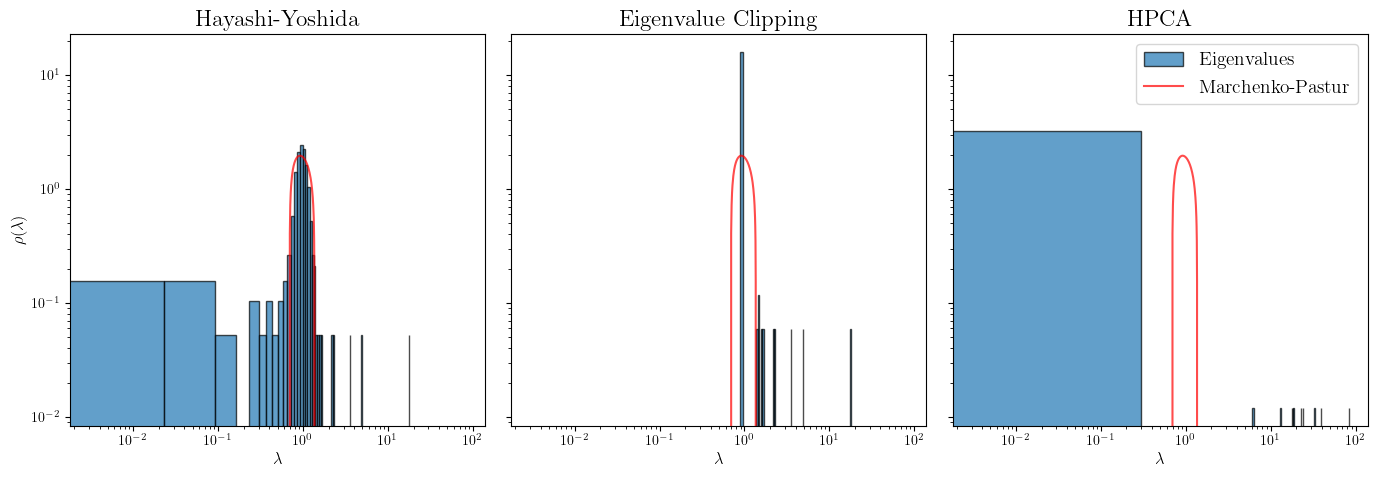

In [134]:
fig, ax = plt.subplots(1, 3, figsize=(14,5), sharey=True)

lower_lim = np.min([np.min(eigvals_day), np.min(eigvals_clipped_day), np.min(eigvals_hpca_day)])
upper_lim = np.max([np.max(eigvals_day), np.max(eigvals_clipped_day), np.max(eigvals_hpca_day)])

x_day, mp0_day = MP0(eigvals_day, N_filtered, T, 1, lower_lim, upper_lim)
ax[0].hist(eigvals_day, bins=N_filtered, density=True, edgecolor='black', alpha=0.7)
ax[0].plot(x_day, mp0_day, color='red', alpha=0.7)
ax[0].set_title('Hayashi-Yoshida')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel(r'$\lambda$')
ax[0].set_ylabel(r'$\rho(\lambda)$')

x_clipped_day, mp0_clipped_day = MP0(eigvals_clipped_day, N_filtered, T, 1, lower_lim, upper_lim)
ax[1].hist(eigvals_clipped_day, bins=N_filtered, density=True, edgecolor='black', alpha=0.7)
ax[1].plot(x_clipped_day, mp0_clipped_day, color='red', alpha=0.7)
ax[1].set_title('Eigenvalue Clipping')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel(r'$\lambda$')

x_hpca_day, mp0_hpca_day = MP0(eigvals_hpca_day, N_filtered, T, 1, lower_lim, upper_lim)
ax[2].hist(eigvals_hpca_day, bins=N_filtered, density=True, edgecolor='black', alpha=0.7, label='Eigenvalues')
ax[2].plot(x_hpca_day, mp0_hpca_day, color='red', alpha=0.7, label='Marchenko-Pastur')
ax[2].set_title('HPCA')
ax[2].set_xscale('log')
ax[2].set_yscale('log')
ax[2].set_xlabel(r'$\lambda$')
ax[2].legend(loc='upper right')

plt.tight_layout()
plt.savefig('../figures/eigenvalues_day.pdf', dpi=300)

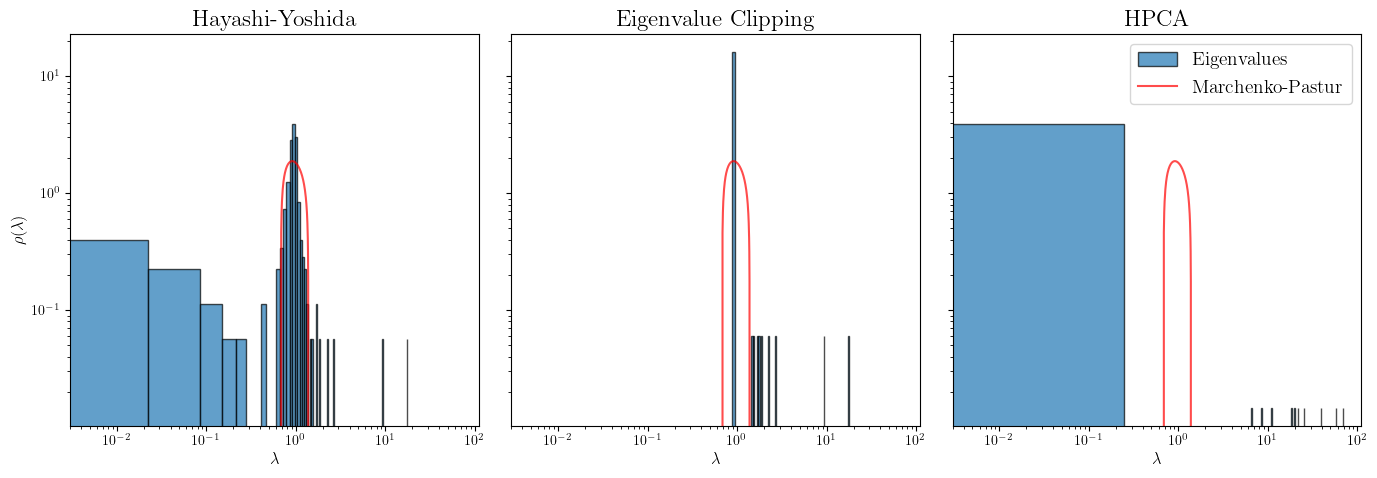

In [135]:
fig, ax = plt.subplots(1, 3, figsize=(14,5), sharey=True)

lower_lim = np.min([np.min(eigvals_month), np.min(eigvals_clipped_month), np.min(eigvals_hpca_month)])
upper_lim = np.max([np.max(eigvals_month), np.max(eigvals_clipped_month), np.max(eigvals_hpca_month)])

x_month, mp0_month = MP0(eigvals_month, N_unfiltered, T, 1, lower_lim, upper_lim)
ax[0].hist(eigvals_month, bins=N_filtered, density=True, edgecolor='black', alpha=0.7)
ax[0].plot(x_month, mp0_month, color='red', alpha=0.7)
ax[0].set_title('Hayashi-Yoshida')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel(r'$\lambda$')
ax[0].set_ylabel(r'$\rho(\lambda)$')

x_clipped_month, mp0_clipped_month = MP0(eigvals_clipped_month, N_unfiltered, T, 1, lower_lim, upper_lim)
ax[1].hist(eigvals_clipped_month, bins=N_filtered, density=True, edgecolor='black', alpha=0.7)
ax[1].plot(x_clipped_month, mp0_clipped_month, color='red', alpha=0.7)
ax[1].set_title('Eigenvalue Clipping')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel(r'$\lambda$')

x_hpca_month, mp0_hpca_month = MP0(eigvals_hpca_month, N_unfiltered, T, 1, lower_lim, upper_lim)
ax[2].hist(eigvals_hpca_month, bins=N_filtered, density=True, edgecolor='black', alpha=0.7, label='Eigenvalues')
ax[2].plot(x_hpca_month, mp0_hpca_month, color='red', alpha=0.7, label='Marchenko-Pastur')
ax[2].set_title('HPCA')
ax[2].set_xscale('log')
ax[2].set_yscale('log')
ax[2].set_xlabel(r'$\lambda$')
ax[2].legend(loc='upper right')

plt.tight_layout()
plt.savefig('../figures/eigenvalues_month.pdf', dpi=300)

**Matrices**

/var/folders/5j/w6vdlj1n4fq45bh11q5mwhkw0000gn/T/ipykernel_62198/3787808459.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, .9, 1])


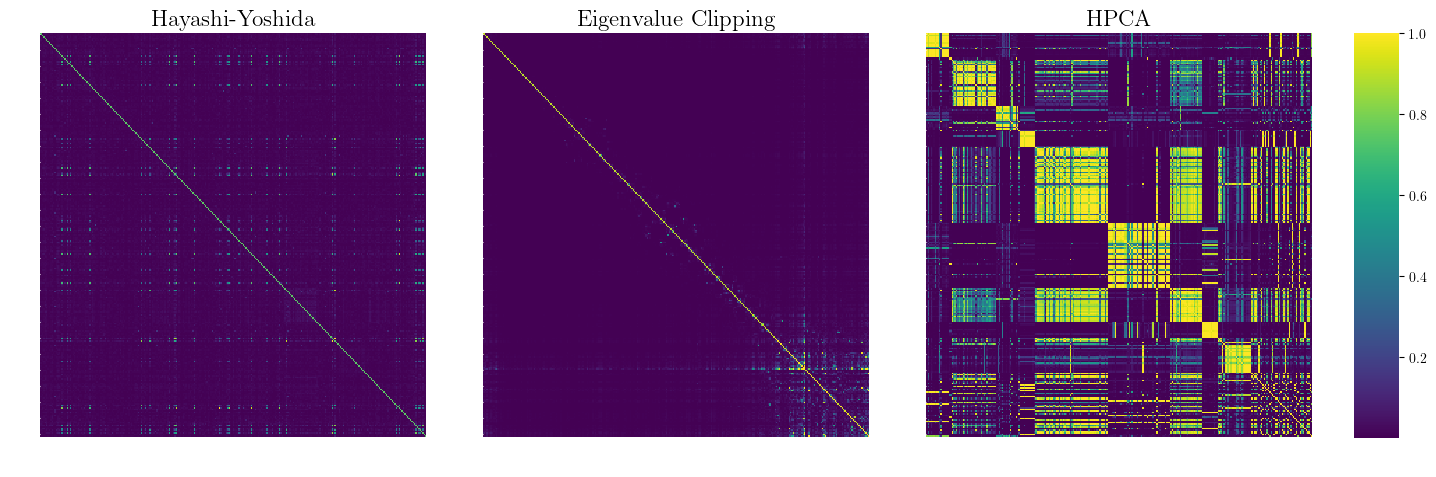

In [136]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
cbar_ax = fig.add_axes([.91, .1, .03, .81])

sns.heatmap(np.abs(corr_raw_day.iloc[:,1:].to_numpy()), ax=ax[0], cmap='viridis', cbar_ax=cbar_ax)
ax[0].set_title('Hayashi-Yoshida')

for tick_label in ax[0].get_xticklabels():
    tick_label.set_color("white")
for tick_label in ax[0].get_yticklabels():
    tick_label.set_color("white")

ax[0].tick_params(axis='x', colors='white')
ax[0].tick_params(axis='y', colors='white')

sns.heatmap(np.abs(corr_clipped_day), ax=ax[1], cmap='viridis', cbar_ax=cbar_ax)
ax[1].set_title('Eigenvalue Clipping')

for tick_label in ax[1].get_xticklabels():
    tick_label.set_color("white")
for tick_label in ax[1].get_yticklabels():
    tick_label.set_color("white")

ax[1].tick_params(axis='x', colors='white')
ax[1].tick_params(axis='y', colors='white')

sns.heatmap(np.abs(corr_hpca_day.iloc[:,1:].to_numpy()), ax=ax[2], cmap='viridis', cbar_ax=cbar_ax)
ax[2].set_title('HPCA')

for tick_label in ax[2].get_xticklabels():
    tick_label.set_color("white")
for tick_label in ax[2].get_yticklabels():
    tick_label.set_color("white")

ax[2].tick_params(axis='x', colors='white')
ax[2].tick_params(axis='y', colors='white')

plt.tight_layout(rect=[0, 0, .9, 1])
plt.savefig('../figures/correlation_day.pdf', dpi=300)

/var/folders/5j/w6vdlj1n4fq45bh11q5mwhkw0000gn/T/ipykernel_62198/2440261458.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, .9, 1])


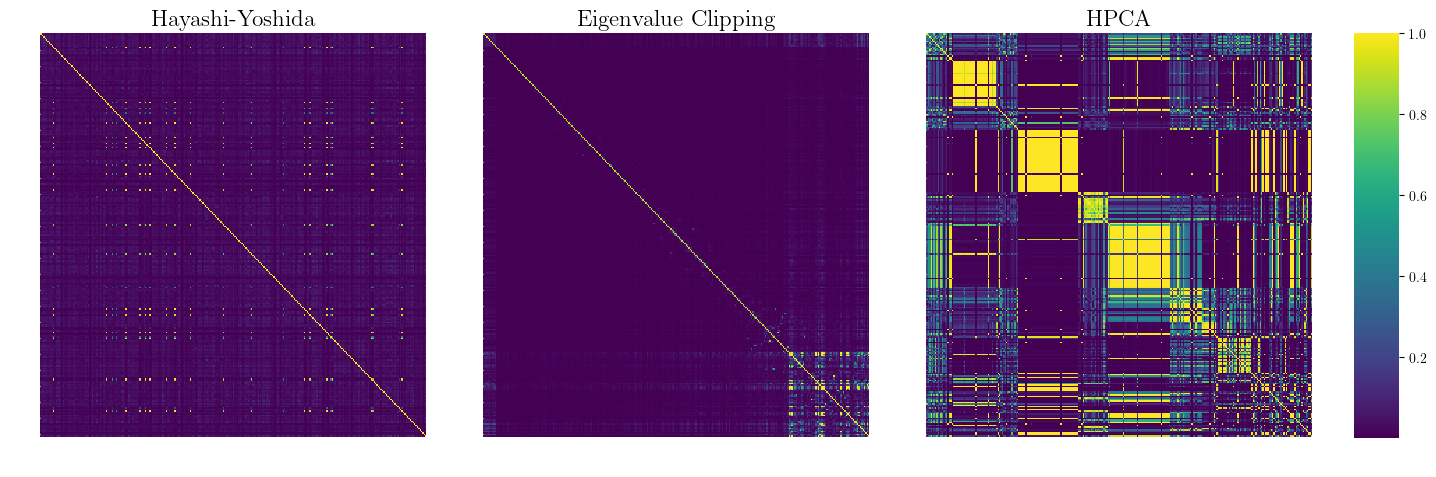

In [137]:
fig, ax = plt.subplots(1, 3, figsize=(15,5))
cbar_ax = fig.add_axes([.91, .1, .03, .81])

sns.heatmap(np.abs(corr_raw_month.iloc[:,1:].to_numpy()), ax=ax[0], cmap='viridis', cbar_ax=cbar_ax)
ax[0].set_title('Hayashi-Yoshida')

for tick_label in ax[0].get_xticklabels():
    tick_label.set_color("white")
for tick_label in ax[0].get_yticklabels():
    tick_label.set_color("white")

ax[0].tick_params(axis='x', colors='white')
ax[0].tick_params(axis='y', colors='white')

sns.heatmap(np.abs(corr_clipped_month), ax=ax[1], cmap='viridis', cbar_ax=cbar_ax)
ax[1].set_title('Eigenvalue Clipping')

for tick_label in ax[1].get_xticklabels():
    tick_label.set_color("white")
for tick_label in ax[1].get_yticklabels():
    tick_label.set_color("white")

ax[1].tick_params(axis='x', colors='white')
ax[1].tick_params(axis='y', colors='white')

sns.heatmap(np.abs(corr_hpca_month.iloc[:,1:].to_numpy()), ax=ax[2], cmap='viridis', cbar_ax=cbar_ax)
ax[2].set_title('HPCA')

for tick_label in ax[2].get_xticklabels():
    tick_label.set_color("white")
for tick_label in ax[2].get_yticklabels():
    tick_label.set_color("white")

ax[2].tick_params(axis='x', colors='white')
ax[2].tick_params(axis='y', colors='white')

plt.tight_layout(rect=[0, 0, .9, 1])
plt.savefig('../figures/correlation_month.pdf', dpi=300)